# **Import Needed Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Text processing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import string

# Machine Learning
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier as randomForestClassifier
from sklearn.svm import SVC as svm

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

# **import data**

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'imdb-dataset-of-50k-movie-reviews' dataset.
Path to dataset files: /kaggle/input/imdb-dataset-of-50k-movie-reviews


# **Read Data**

In [3]:
df = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
df.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


# **EDA**

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [6]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [7]:
df.isnull().sum()

,0
review,0
sentiment,0


In [8]:
df.dropna(inplace=True)

In [9]:
df.sentiment.value_counts()

,count
sentiment,
positive,25000
negative,25000


<Axes: xlabel='count', ylabel='sentiment'>

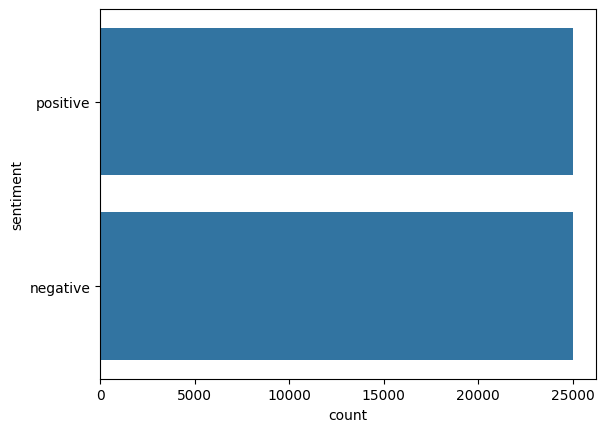

In [10]:
sns.countplot(df.sentiment)

data is balanced

# **Text Preprocessing**

In [11]:
class TextPreprocessor:
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        # Add movie-specific stop words
        self.stop_words.update(['movie', 'film', 'movies', 'films', 'watch', 'watched', 'see', 'saw'])
        self.lemmatizer = WordNetLemmatizer()

    def clean_text(self, text):
        """Clean and preprocess text"""
        if isinstance(text, float):
            text = str(text)

        # Convert to lowercase
        text = text.lower()

        # Remove HTML tags
        text = re.sub(r'<.*?>', '', text)

        # Remove URLs
        text = re.sub(r'http\S+', '', text)

        # Remove punctuation and numbers
        text = re.sub(r'[^\w\s]', ' ', text)
        text = re.sub(r'\d+', '', text)

        # Remove extra whitespace
        text = ' '.join(text.split())

        return text

    def tokenize_and_lemmatize(self, text):
        """Tokenize and lemmatize text"""
        tokens = word_tokenize(text)

        # Remove stopwords and short tokens, then lemmatize
        tokens = [self.lemmatizer.lemmatize(token) for token in tokens
                 if token not in self.stop_words and len(token) > 2]

        return tokens

    def preprocess_dataset(self, df, text_column='review'):
        """Preprocess entire dataset"""
        print("Cleaning text...")
        df['cleaned_review'] = df[text_column].apply(self.clean_text)

        print("Tokenizing and lemmatizing...")
        df['tokens'] = df['cleaned_review'].apply(self.tokenize_and_lemmatize)

        df['processed_text'] = df['tokens'].apply(lambda x: ' '.join(x))

        return df

# Initialize preprocessor
preprocessor = TextPreprocessor()

# Preprocess data
print("Preprocessing text data...")
df = preprocessor.preprocess_dataset(df)

print("\nPreprocessing completed!")
print(df[['review', 'cleaned_review', 'tokens']].head())

Preprocessing text data...
Cleaning text...
Tokenizing and lemmatizing...

Preprocessing completed!
                                              review  \
0  One of the other reviewers has mentioned that ...   
1  A wonderful little production. <br /><br />The...   
2  I thought this was a wonderful way to spend ti...   
3  Basically there's a family where a little boy ...   
4  Petter Mattei's "Love in the Time of Money" is...   

                                      cleaned_review  \
0  one of the other reviewers has mentioned that ...   
1  a wonderful little production the filming tech...   
2  i thought this was a wonderful way to spend ti...   
3  basically there s a family where a little boy ...   
4  petter mattei s love in the time of money is a...   

                                              tokens  
0  [one, reviewer, mentioned, watching, episode, ...  
1  [wonderful, little, production, filming, techn...  
2  [thought, wonderful, way, spend, time, hot, su...  
3  [ba

# **Train test split**

In [12]:
X = df['processed_text']
y = df['sentiment']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# **Convert text column to numeric vector**

In [14]:
TfidfVectorizer=TfidfVectorizer(max_features=5000,ngram_range=(1,2))
X_train_vec=TfidfVectorizer.fit_transform(X_train)
X_test_vec=TfidfVectorizer.transform(X_test)

# **Machine Learning Models**

# **1.Naive Bays**

In [15]:
NV=MultinomialNB()

NV.fit(X_train_vec,y_train)

MultinomialNB()

In [16]:
y_pred = NV.predict(X_test_vec)

In [17]:
print(accuracy_score(y_test, y_pred))

0.8606


In [18]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.87      0.84      0.86      5000
    positive       0.85      0.88      0.86      5000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



# **2.Logistic Regression**

In [19]:
LR=LogisticRegression(random_state=42,max_iter=1000)


LR.fit(X_train_vec,y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [20]:
y_pred = LR.predict(X_test_vec)

In [21]:
print(accuracy_score(y_test, y_pred))

0.8924


In [22]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.90      0.88      0.89      5000
    positive       0.89      0.90      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



# **3.Random Forest**

In [23]:
RF=randomForestClassifier()

RF.fit(X_train_vec,y_train)

RandomForestClassifier()

In [24]:
y_pred = RF.predict(X_test_vec)

In [25]:
print(f'ACCURACY: {RF.score(X_test_vec,y_test)}')

ACCURACY: 0.8541


In [26]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.85      0.86      0.86      5000
    positive       0.86      0.85      0.85      5000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



# **SO the best model is Logistic Regression**

# **test model**

In [28]:
test_text = df['review'][2000]
test_text

"Stranded in Space (1972) MST3K version - a very not good TV movie pilot, for a never to be made series, in which an astronaut finds himself trapped on Earth's evil twin. Having a planet of identical size and mass orbiting in the same plane as the earth, but on the opposite side of the sun, is a well worn SF chestnut - the idea is over 2,000 years old, having been invented by the Ancient Greeks. In this version the Counter World is run as an Orwellian 'perfect' society. Where, for totally inexplicable reasons, everyone speaks English and drives late model American cars. After escaping from his prisonlike hospital, the disruptive Earthian is chased around Not Southern California by TV and bad movie stalwart Cameron Mitchell who, like his minions, wears double breasted suits and black polo neck jumpers - a stylishly evil combination which I fully intend to adopt if ever I become a totalitarian overlord. Our hero escapes several times before ending up gazing at the alien world's three moo

In [30]:
test_text_processed = preprocessor.clean_text(test_text)
test_text_processed = preprocessor.tokenize_and_lemmatize(test_text_processed)
test_text_processed = [' '.join(test_text_processed)]
test_text_processed

['stranded space mstk version good pilot never made series astronaut find trapped earth evil twin planet identical size mass orbiting plane earth opposite side sun well worn chestnut idea year old invented ancient greek version counter world run orwellian perfect society totally inexplicable reason everyone speaks english drive late model american car escaping prisonlike hospital disruptive earthian chased around southern california bad stalwart cameron mitchell like minion wear double breasted suit black polo neck jumper stylishly evil combination fully intend adopt ever become totalitarian overlord hero escape several time ending gazing alien world three moon wondering aloud ever get home thus setting one man alone hostile world making new friend week moving end every episode show beloved industry fugitive incredible hulk littlest hobo etc curiously weirdest bit though title sequence somewhere stranded space first airing title stranger mstk version somehow acquired footage prisoner l

In [32]:
test_text_vc = TfidfVectorizer.transform(test_text_processed)

In [35]:
test_text = LR.predict(test_text_vc)
print(test_text)

['negative']
